In [1]:
import os
import polars as pl
import datetime

# Get the filenames

In [2]:
directory = rf'../../data/concatenated/'
years = os.listdir(directory)

parquet_files = []
for year in years:
    file_dir = os.path.join(directory, year)

    # Get 
    parquet_file_in_dir = [os.path.normpath(os.path.join(file_dir, f)) for f in os.listdir(file_dir) if f.endswith('.parquet.gz')]
    parquet_files.extend(parquet_file_in_dir)

print(parquet_files)

['..\\..\\data\\concatenated\\2019\\2019 Taxi and Ride Hailing Records.parquet.gz', '..\\..\\data\\concatenated\\2020\\2020 Taxi and Ride Hailing Records.parquet.gz', '..\\..\\data\\concatenated\\2021\\2021 Taxi and Ride Hailing Records.parquet.gz', '..\\..\\data\\concatenated\\2022\\2022 Taxi and Ride Hailing Records.parquet.gz', '..\\..\\data\\concatenated\\2023\\2023 Taxi and Ride Hailing Records.parquet.gz', '..\\..\\data\\concatenated\\2024\\2024 Taxi and Ride Hailing Records.parquet.gz']


# Processing

In [3]:
for file in parquet_files:
    print(f"Processing {file}")
    # Read the file
    df = pl.read_parquet(file)

    # Get the year 
    year = file.split('\\')[-2] # For filename purposes

    # Iterate over the boroughs
    for borough in ["EWR", "Brooklyn", "Manhattan", "Staten Island", "Queens", "Bronx"]:
        print(f"\tProcessing {borough} for year {year}.")
        
        # Initial aggregation
        print(f"\t\tDoing initial aggregation.")
        df_agg = (
            df
            .filter(pl.col("PUBorough") == borough) 
            .group_by([
                'txn_date','txn_hour',
                'timestamp_hour',
                'PUBorough','ride_type'
            ])
            .agg([
                pl.col("num_txns").sum().alias("num_txns"),
                pl.col("total_amount").sum().alias("total_amount"),
            ])
        )

        # # Pivot the ride types
        # print(f"\t\tPivot the ride types.")
        

        # Export the dataframe
        print(f"\t\tExport the dataframe in parquet format.\n")
        parquet_filename = f"..\\..\\data\\processed by borough\\{borough}\\{borough} TLC Records - {year}.parquet.gz"
        df_agg.write_parquet(parquet_filename, compression="gzip")

print("DONE")

Processing ..\..\data\concatenated\2019\2019 Taxi and Ride Hailing Records.parquet.gz
	Processing EWR for year 2019.
		Doing initial aggregation.
		Export the dataframe in parquet format.

	Processing Brooklyn for year 2019.
		Doing initial aggregation.
		Export the dataframe in parquet format.

	Processing Manhattan for year 2019.
		Doing initial aggregation.
		Export the dataframe in parquet format.

	Processing Staten Island for year 2019.
		Doing initial aggregation.
		Export the dataframe in parquet format.

	Processing Queens for year 2019.
		Doing initial aggregation.
		Export the dataframe in parquet format.

	Processing Bronx for year 2019.
		Doing initial aggregation.
		Export the dataframe in parquet format.

Processing ..\..\data\concatenated\2020\2020 Taxi and Ride Hailing Records.parquet.gz
	Processing EWR for year 2020.
		Doing initial aggregation.
		Export the dataframe in parquet format.

	Processing Brooklyn for year 2020.
		Doing initial aggregation.
		Export the dat

# Concatenate by borough

In [37]:
processed_path = f"..\\..\\data\\processed by borough"
main_directories = [f"{processed_path}\\{d}" for d in os.listdir(processed_path) if os.path.isdir(os.path.join(processed_path, d))]

dfs = []
for main_dir in main_directories:
    print(main_dir)
    # Get the borough name from the directory
    borough = main_dir.split('\\')[-1]
    parquet_files = [rf"{main_dir}\{f}" for f in os.listdir(main_dir) if f.endswith('.parquet.gz')]

    # Loop through the parquet files
    for filename in parquet_files:
        df = pl.read_parquet(filename)
        df = df.filter(
                (pl.col("txn_date").cast(pl.Date).dt.year() >= 2019) & 
                (pl.col("txn_date").cast(pl.Date).dt.year() <= 2024)
            )
        dfs.append(df)
        
    # Concatenate the dataframes
    df = pl.concat(dfs)
    df_agg = (
            df
            .pivot(
                values=["num_txns", "total_amount"],  # Specify two value columns
                index=["txn_date", "txn_hour", "timestamp_hour"],            # Index column
                on="ride_type",              # Columns to pivot on
                maintain_order=True,
                aggregate_function="sum" 
            )
            .sort('timestamp_hour', nulls_last=True)
            .fill_null(value=0)
        )
    df_agg.write_parquet(rf"..\\..\\data\\final processed\\{borough} - all.parquet.gz", compression="gzip")

..\..\data\processed by borough\Bronx
..\..\data\processed by borough\Brooklyn
..\..\data\processed by borough\EWR
..\..\data\processed by borough\Manhattan
..\..\data\processed by borough\Queens
..\..\data\processed by borough\Staten Island


# Testing

In [38]:
df = pl.read_parquet(rf"..\\..\\data\\final processed\\Manhattan - all.parquet.gz")
df.head()

txn_date,txn_hour,timestamp_hour,num_txns_Yellow Taxi Trip Records,num_txns_For-Hire Vehicle Trip Records,num_txns_Green Taxi Trip Records,num_txns_Uber,num_txns_Lyft,num_txns_Juno,num_txns_Via,total_amount_Yellow Taxi Trip Records,total_amount_For-Hire Vehicle Trip Records,total_amount_Green Taxi Trip Records,total_amount_Uber,total_amount_Lyft,total_amount_Juno,total_amount_Via
date,i32,datetime[μs],i32,i32,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64
2019-01-01,0,2019-01-01 00:00:00,12761,44746,886,0,0,0,0,72197.522779,0.0,12816.720385,0.0,0.0,0.0,0.0
2019-01-01,1,2019-01-01 01:00:00,14747,55230,818,0,0,0,0,92587.375479,0.0,11688.51304,0.0,0.0,0.0,0.0
2019-01-01,2,2019-01-01 02:00:00,12602,53057,701,0,0,0,0,86116.867964,0.0,10704.114833,0.0,0.0,0.0,0.0
2019-01-01,3,2019-01-01 03:00:00,9869,42074,625,0,0,0,0,70675.309449,0.0,8821.573028,0.0,0.0,0.0,0.0
2019-01-01,4,2019-01-01 04:00:00,6399,28974,464,0,0,0,0,58110.657422,0.0,6955.466833,0.0,0.0,0.0,0.0


# Sample plots

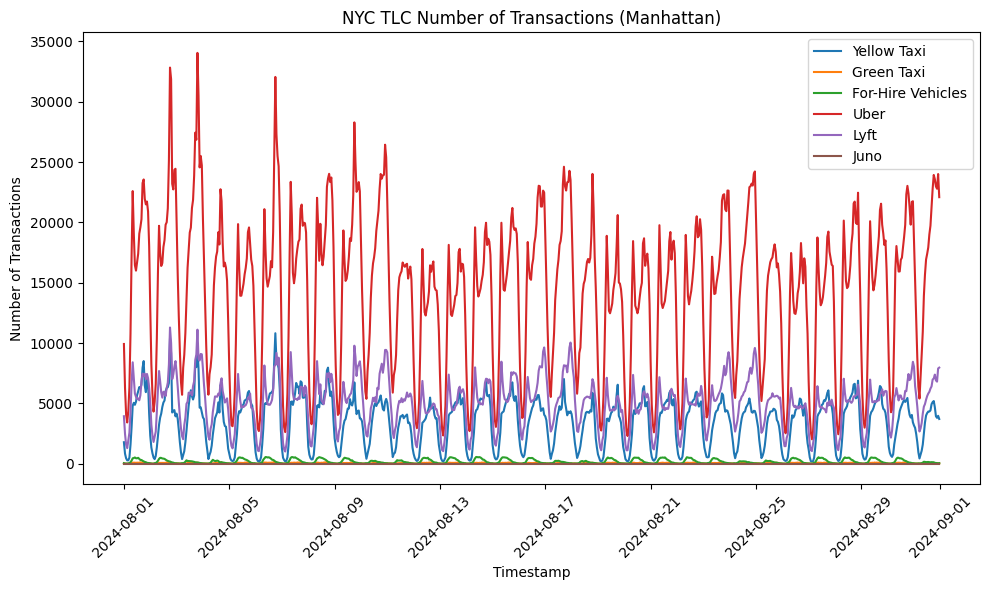

In [50]:
import matplotlib.pyplot as plt

filtered_df = df.filter(
    (pl.col("timestamp_hour") >= pl.datetime(2024, 8, 1)) &
    (pl.col("timestamp_hour") < pl.datetime(2024, 9, 1))
)

# Convert to lists for plotting
timestamps = filtered_df["timestamp_hour"].to_list()
yellow_taxis = filtered_df["num_txns_Yellow Taxi Trip Records"].to_list()
green_taxis = filtered_df["num_txns_Green Taxi Trip Records"].to_list()
uber = filtered_df["num_txns_Uber"].to_list()
lyft = filtered_df["num_txns_Lyft"].to_list()
juno = filtered_df["num_txns_Juno"].to_list()
fhv = filtered_df["num_txns_For-Hire Vehicle Trip Records"].to_list()


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(timestamps, yellow_taxis, label="Yellow Taxi")
plt.plot(timestamps, green_taxis, label="Green Taxi")
plt.plot(timestamps, fhv, label="For-Hire Vehicles")
plt.plot(timestamps, uber, label="Uber")
plt.plot(timestamps, lyft, label="Lyft")
plt.plot(timestamps, juno, label="Juno")
plt.title("NYC TLC Number of Transactions (Manhattan)")
plt.xlabel("Timestamp")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
(
    df
    .group_by(['txn_date'])
    .agg(
        pl.col('txn_hour').n_unique().alias('num_hours')
    )
    .sort('txn_date')
)

txn_date,num_hours
date,u32
2019-01-01,24
2019-01-02,24
2019-01-03,24
2019-01-04,24
2019-01-05,24
…,…
2024-08-27,24
2024-08-28,24
2024-08-29,24


In [40]:
(
    df
    .group_by(['txn_date'])
    .agg(
        pl.col('txn_hour').n_unique().alias('num_hours')
    )
    .sort('txn_date')
).filter(pl.col("num_hours") < 24)

txn_date,num_hours
date,u32
